# Standard Bank Tech Impact Challenge: Animal classification

The objective of this challenge is to create a machine learning model to accurately predict the likelihood that an image contains a zebra, as opposed to an elephant. While this may be an easy task for humans, elephants, and zebras, your computer will find it a bit more difficult.

The total dataset contains 13,999 images of zebras and elephants, sampled from the Snapshot Serengeti collection of more than 6 million animals.

Your task is to predict whether a given image contains a zebra or elephant. For each unique image ID in the test set you should estimate the likelihood that the image contains a zebra or elephant, with an estimated probability value between 0 and 1. A value of 1 represents a zebra and 0 represents an elephant. These images do not contain both simultaneously. It is therefore only a binary classification task.

### Dataset:
You are given 13,999 photos each with a unique identifier. The data is given in jpeg format. Each photo has already been resized to 330x330 pixels.

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'2.3.0'

## Part 1 - Data Augmentation & Preprocessing

Data augmentation is an essential way to fight overfitting for computer vision models.
In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better. 

This can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance.

In [76]:
# Here I have created an instance of the ImageDataGenerator module to
# illustrate the capabilities of the augmentationt transformations on
# the image dataset

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Above you will find a few of the options available for augmenting the images in your dataset with ImageDataGenerator.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

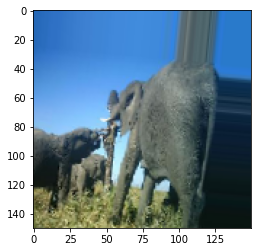

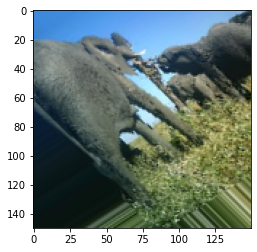

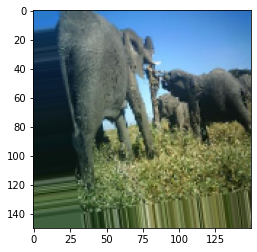

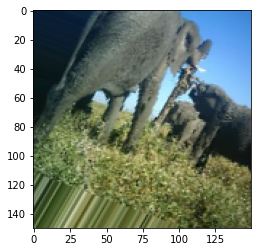

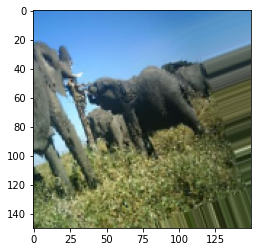

In [77]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import os

# Now I shall import a single image and showcase the results of various
# augmentation techniques

base_dir = 'C:/Users/User/Documents/Varisty/Masters/Techpreneurship Program/Assignments/Final Project/dataset/'
direc = os.path.join(base_dir, 'Train')
train_el_dir = os.path.join(direc, 'elephants')
elephants = os.listdir(train_el_dir)

img_path = os.path.join(train_el_dir, elephants[2])

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images. It loops indefinitely, so we need to include a `break` the loop.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

The images supplied showcase the manner in which the augmentation occurs, by few of the techniques given in the datagen instance above for ImageDataGenerator. This shows how the images change upon augmentation and how the model comes to learn off these. Now we will preprocess and augment the training, validation and test sets, properly. 

### Preprocessing the Training set

In [149]:
train_datagen = ImageDataGenerator(
        rescale=1./255, featurewise_center=True, featurewise_std_normalization=True,
        shear_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
training_set = train_datagen.flow_from_directory(
        directory=direc,
        target_size=(64,64),
        batch_size=32,
        class_mode='binary')

Found 9999 images belonging to 2 classes.


The target size of 64x64 pixels was used as 32x32 pixels had a much lower test accuracy, and 128x128 pixels takes much longer to run - for only a small increase in accuracy. The batch size also denotes the size of groups of training (or later, validation and test sets, too) data that are scaled at a time. Two sizes were evaluated: 32 and 64, of which a batch size of 32 images has a higher test accuracy. This value is used.

The ImageDataGenerator class can be used to rescale pixel values from the range of 0-255 to the range 0-1 (by dividing by 255) which is preferred for neural network models. This would act to normalize the data for the model. Without any further preprcessing, by means of standardization or normalization, the Test Accuracy was 63.75%.

The data, however, can be centred/standardised in a featurewise or samplewise manner (i.e., overall for the training set, or per image), which may be beneficial when training neural networks, especially with standardization as the dataset sums to zero and the inputs are small values in the rough range of about -3.0 to 3.0 (e.g. 99.7 of the values will fall within three standard deviations of the mean).

Therefore, to assist in identifying the best performing model preprocessing technique, normalization and standardization techniques were both tested and evaluated. Below is a summary of results obtained using an 'adam' optimizer and 'binary crossentropy' loss function, with the accuracy metric included. As it stands, a *featurewise standardization* is the best performing preprocessing. 

For rescaling & featurewise standardisation: *test accuracy of 78.4%.*
For rescaling & samplewise standardisation: *test accuracy of 72.90%.*
For rescaling & featurewise normalization: *test accuracy of 71.85%.*
Only rescaling: *test accuracy of 63.8%.*

### Preprocessing the validation set

In [150]:
valid_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True)
valid_direc = os.path.join(base_dir, 'Valid')

validation_set = valid_datagen.flow_from_directory(
    directory=valid_direc,
    target_size=(64,64),
    batch_size=32,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.


### Preprocessing the Test set

In [151]:
test_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=True, featurewise_std_normalization=True)
test_direc = os.path.join(base_dir, 'Test')

test_set = test_datagen.flow_from_directory(
        directory=test_direc,
        target_size=(64,64),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


## Part 2 - Choosing ML Model & Building It

### Initialising the CNN

In [152]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [153]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

### Step 2 - Pooling

In [154]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [155]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

In [156]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [157]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [158]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Model Training

### Compiling the CNN

In [159]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [160]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

history = cnn.fit(training_set, validation_data = validation_set, epochs = 5, verbose=2, callbacks=[earlystopping])

Epoch 1/5
313/313 - 74s - loss: 0.4749 - accuracy: 0.7744 - val_loss: 0.6799 - val_accuracy: 0.6545
Epoch 2/5
313/313 - 75s - loss: 0.3715 - accuracy: 0.8384 - val_loss: 0.6129 - val_accuracy: 0.6615
Epoch 3/5
313/313 - 76s - loss: 0.3404 - accuracy: 0.8524 - val_loss: 0.6830 - val_accuracy: 0.6595
Epoch 4/5
313/313 - 74s - loss: 0.3097 - accuracy: 0.8656 - val_loss: 0.6850 - val_accuracy: 0.6585
Epoch 5/5
313/313 - 72s - loss: 0.2926 - accuracy: 0.8760 - val_loss: 0.9032 - val_accuracy: 0.6315


## Part 4 - Model Tuning

- Verbose was put on 2 so the details of the Model.fit() method could be shown, along with the results.


- The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. This parameter needs to be optimised. This was done by using a callback method (EarlyStopping) to halt the process once the validation loss reaches a minimum - and checks it by continuing 5 more epochs afterwards - which allows us to view the optimum number of epochs to use for the model so as to prevent overfitting.


- optimizer in the compile() method was evaluated for the best method. Adam is noted to be one of the best optimizer methods, and RMSProp is also dually noted across various articles. For the sake of this project, two optimizers were evaluated: 'adam' and 'rmsprop'. Adam did in fact work out to be better, and is supported by literature to be an appropriate method for problems with very noisy/or sparse gradients; also, instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance). Adam is a popular algorithm in the field of deep learning because it achieves good results fast and that is why it was chosen as the optimizer function.


- for the loss function, the 'binary crossentropy' function is used as it noted widely to be intended for use with binary classification tasks, where the target values are in the set {0, 1}. To be specific, cross entropy is equivalent to fitting the model with maximum likelihood estimation - which minimises dissimilarity between the training data empirical distribution and the model's induced distribution. These estimators have good asymptomatic properties and are consistent, as well as being statistically significant. This cross-entropy function gives well-calibrated probabilities.

## Part 5 - Model Assessment

Text(0.5, 1.0, 'Training and validation loss')

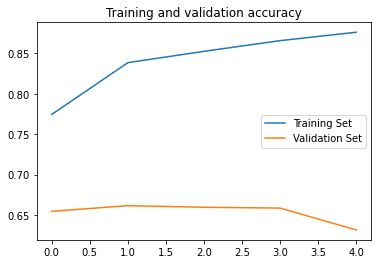

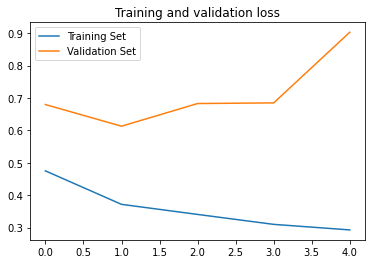

In [161]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training Set')
plt.plot(epochs, val_acc, label='Validation Set')
plt.legend()
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training Set')
plt.plot(epochs, val_loss, label='Validation Set')
plt.legend()
plt.title('Training and validation loss')

### Test model on test set

In [162]:
_, acc = cnn.evaluate_generator(test_set, steps=len(test_set), verbose=2)
print('Test Accuracy: %.2f' % (acc * 100))

63/63 - 6s - loss: 0.5289 - accuracy: 0.7610
Test Accuracy: 76.10


## Part 4 - Making a single prediction

In [147]:
from keras.preprocessing import image

single_direc = os.path.join(base_dir, 'single_prediction')
ellie = os.listdir(single_direc)
img_path = os.path.join(single_direc, ellie[0])

test_image = image.load_img(img_path, target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = cnn.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'zebra'
else:
  prediction = 'elephant'

In [148]:
print(prediction)

zebra
